In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from train_csv import train_dual_encoder_csv

train_df = pd.read_csv("/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_text/flickr8k_train.csv")

train_dual_encoder_csv(
    train_csv="/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_text/flickr8k_train.csv",
    image_dir="/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_images/",
    vocab_path="/content/vocab.pkl",
    output_path="/content/dual_cont_encoder_csv.pth"
)

In [ ]:
from train_hf import train_dual_encoder_hf
from datasets import load_dataset

ds = load_dataset("jxie/flickr8k")

train_dual_encoder_hf(
    dataset=ds["train"],
    vocab_path="/content/vocab-HF-8K.pkl",
    output_path="/content/dual_hf_encoder.pth",
    caption_field="caption_0"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/687 [00:00<?, ?B/s]

data/train-00000-of-00002-2f8f6bfa852eac(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/train-00001-of-00002-2173151d8cd6c7(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/validation-00000-of-00001-7025a2b59(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

data/test-00000-of-00001-42a2661d12c73e4(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


Epoch 1/5, Loss: 3.0115
Epoch 2/5, Loss: 1.8471
Epoch 3/5, Loss: 1.2128
Epoch 4/5, Loss: 0.8399
Epoch 5/5, Loss: 0.6169
Model saved to /content/dual_hf_encoder.pth


In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

from dataloader_hf import FlickrDataset, collate_fn
from cap_model_m1 import ResNetLSTMCaptionModel
from datasets import load_dataset

ds = load_dataset("jxie/flickr8k")

dataset = FlickrDataset(
    ds["train"],
    vocab_path="/content/vocab-HF-8K.pkl"
)

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

images, captions, lengths = next(iter(loader))

model = ResNetLSTMCaptionModel(
    vocab_size=len(dataset.word2int)
)

outputs = model(images, captions, lengths)

print("Images:", images.shape)
print("Captions:", captions.shape)
print("Outputs:", outputs.shape)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_idx)
loss = criterion(
    outputs.reshape(-1, outputs.size(-1)),
    captions[:, 1:].reshape(-1)
)

print("Sanity loss:", loss.item())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


Images: torch.Size([2, 3, 224, 224])
Captions: torch.Size([2, 13])
Outputs: torch.Size([2, 12, 3869])
Sanity loss: 8.245420455932617


In [ ]:
from datasets import load_dataset
from dataloader_hf import FlickrDataset
import torch

from train_hf_full import fit_model_hf
from cap_model_m1 import ResNetLSTMCaptionModel   # your M1 model

ds = load_dataset("jxie/flickr8k")

train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds  = ds["test"]

tmp_dataset = FlickrDataset(
    train_ds,
    vocab_path="/content/vocab-HF-8K.pkl"
)

VOCAB_SIZE = len(tmp_dataset.word2int)


# 3. Initialize model (M1)
model = ResNetLSTMCaptionModel(
    vocab_size=VOCAB_SIZE,
    embed_dim=256,
    hidden_dim=512
)


# 4. Train + validate + test
history = fit_model_hf(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    vocab_path="/content/vocab-HF-8K.pkl",
    output_model_path="/content/m1_resnet_lstm.pth",
    batch_size=32,
    num_epochs=5,
    lr=1e-4,
    device=torch.device("cuda")
)


Epoch 1/5 | Train: 5.6467 | Val: 4.3166 | Test: 4.3120
Epoch 2/5 | Train: 4.2533 | Val: 4.0056 | Test: 4.0059
Epoch 3/5 | Train: 3.9857 | Val: 3.8201 | Test: 3.8189
Epoch 4/5 | Train: 3.8127 | Val: 3.6944 | Test: 3.6897
Epoch 5/5 | Train: 3.6855 | Val: 3.5985 | Test: 3.5891
Model saved to: /content/m1_resnet_lstm.pth


In [2]:
import pandas as pd

ann = pd.read_csv("/content/annotations_30k.csv")
print(ann.columns)

Index(['raw', 'sentids', 'split', 'filename', 'img_id'], dtype='object')


In [3]:
ann.loc[0, "raw"]

'["Two young guys with shaggy hair look at their hands while hanging out in the yard.", "Two young, White males are outside near many bushes.", "Two men in green shirts are standing in a yard.", "A man in a blue shirt standing in a garden.", "Two friends enjoy time spent together."]'

In [4]:
import re
def tokenize(caption):
    caption = caption.lower().strip()
    caption = re.sub(r"[^\w\s]", "", caption)  # remove punctuation
    return caption.split()

In [5]:
from collections import Counter
import ast
import pickle

def build_vocab_from_flickr30k_csv(
    annotations_csv,
    min_freq=2,
    vocab_output_path="/content/vocab_flickr30k.pkl"
):
    df = pd.read_csv(annotations_csv)
    df_train = df[df["split"] == "train"]

    token_counter = Counter()

    for _, row in df_train.iterrows():
        captions = ast.literal_eval(row["raw"])  # convert string → list
        for caption in captions:
            tokens = tokenize(caption)
            token_counter.update(tokens)

    tokens = [tok for tok, freq in token_counter.items() if freq >= min_freq]

    special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
    vocab_tokens = special_tokens + sorted(tokens)

    word2int = {w: i for i, w in enumerate(vocab_tokens)}
    int2word = {i: w for w, i in word2int.items()}

    vocab = {
        "word2int": word2int,
        "int2word": int2word,
        "specials": special_tokens,
        "min_freq": min_freq
    }

    with open(vocab_output_path, "wb") as f:
        pickle.dump(vocab, f)

    print(f"Flickr30k vocab size: {len(word2int)}")
    return vocab


In [6]:
build_vocab_from_flickr30k_csv(
    annotations_csv="annotations_30k.csv",
    min_freq=2,
    vocab_output_path="vocab_flickr30k.pkl"
)

Flickr30k vocab size: 12136


{'word2int': {'<pad>': 0,
  '<sos>': 1,
  '<eos>': 2,
  '<unk>': 3,
  '0': 4,
  '0095': 5,
  '046': 6,
  '060': 7,
  '1': 8,
  '10': 9,
  '100': 10,
  '1000': 11,
  '104': 12,
  '11': 13,
  '12': 14,
  '1299': 15,
  '13': 16,
  '14': 17,
  '15': 18,
  '16': 19,
  '161': 20,
  '17': 21,
  '1800s': 22,
  '1889': 23,
  '18th': 24,
  '19': 25,
  '1950s': 26,
  '1970s': 27,
  '2': 28,
  '20': 29,
  '2008': 30,
  '2010': 31,
  '2011': 32,
  '2012': 33,
  '20s': 34,
  '20th': 35,
  '21': 36,
  '22': 37,
  '23': 38,
  '23rd': 39,
  '24': 40,
  '25': 41,
  '252': 42,
  '25th': 43,
  '27': 44,
  '28': 45,
  '281': 46,
  '29': 47,
  '2nd': 48,
  '3': 49,
  '30': 50,
  '30s': 51,
  '3113': 52,
  '32': 53,
  '33': 54,
  '330': 55,
  '3443': 56,
  '35': 57,
  '36': 58,
  '37': 59,
  '38': 60,
  '39': 61,
  '3d': 62,
  '3rd': 63,
  '4': 64,
  '40': 65,
  '41': 66,
  '43': 67,
  '44': 68,
  '46': 69,
  '49ers': 70,
  '4th': 71,
  '4wheel': 72,
  '4wheeler': 73,
  '4x4': 74,
  '5': 75,
  '50': 76,
  '5

In [1]:
import pickle

with open("/content/vocab_flickr30k.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocab size:", len(vocab["word2int"]))

Vocab size: 12136


**Calculate Train/Test/Val loss for 30K**

In [6]:
import torch
import pickle
import pandas as pd
from torch.utils.data import DataLoader

from dataloader_hf import Flickr30kDataset, collate_fn
from ret_train_hf import train_dual_encoder_hf, init_m1_model_and_optimizer

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open("/content/vocab_HF-30k.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocab size:", len(vocab["word2int"]))

In [4]:
train_df = pd.read_csv("/content/train_30k.csv")
val_df   = pd.read_csv("/content/val_30k.csv")
test_df  = pd.read_csv("/content/test_30k.csv")

In [5]:
train_ds = Flickr30kDataset(train_df, vocab, image_root="/content/Flickr30k_Images")
val_ds   = Flickr30kDataset(val_df, vocab, image_root="/content/Flickr30k_Images")
test_ds  = Flickr30kDataset(test_df, vocab, image_root="/content/Flickr30k_Images")

In [6]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=2,pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2,pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2,pin_memory=True)

In [7]:
image_encoder, text_encoder, optimizer = init_m1_model_and_optimizer(
    vocab_size=len(vocab["word2int"]),
    device=device
)

In [14]:
train_df_small = train_df.sample(1000, random_state=42)
train_ds = Flickr30kDataset(train_df_small, vocab, image_root="/content/Flickr30k_Images")

In [7]:
!mkdir -p /content/data/processed

In [8]:
history = train_dual_encoder_hf(
    image_encoder,
    text_encoder,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    num_epochs=10,
    device=device,
    save_path="/content/data/processed/m1_best.pth"
)


Epoch [1/10] | Train: 1.9751 | Val: 1.6574 | Test: 1.5819
Epoch [2/10] | Train: 1.3129 | Val: 1.3471 | Test: 1.2575
Epoch [3/10] | Train: 1.0796 | Val: 1.2428 | Test: 1.2161
Epoch [4/10] | Train: 0.9382 | Val: 1.1261 | Test: 1.0535
Epoch [5/10] | Train: 0.8335 | Val: 1.1011 | Test: 0.9983
Epoch [6/10] | Train: 0.7564 | Val: 1.0211 | Test: 1.0194
Epoch [7/10] | Train: 0.7043 | Val: 0.9871 | Test: 0.9536
Epoch [8/10] | Train: 0.6625 | Val: 0.9380 | Test: 0.9324
Epoch [9/10] | Train: 0.6165 | Val: 0.8876 | Test: 0.8784
Epoch [10/10] | Train: 0.5830 | Val: 0.8874 | Test: 0.8719


In [23]:
!cp -r /content/drive/MyDrive/CapstoneProject/Datasets/HF_30K /content/Flickr30k_Images


**Calculate Train/Test/Val loss for 8K**

In [6]:
import torch
import pickle
import pandas as pd
from torch.utils.data import DataLoader

from dataloader_hf import FlickrDataset, collate_fn
from ret_train_hf import train_dual_encoder_hf, init_m1_model_and_optimizer

In [7]:
with open("/content/vocab_8k.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocab size:", len(vocab["word2int"]))

Vocab size: 1981


In [3]:
from datasets import load_dataset

ds = load_dataset("jxie/flickr8k")

train_ds = FlickrDataset(ds["train"], vocab)
val_ds   = FlickrDataset(ds["validation"], vocab)
test_ds  = FlickrDataset(ds["test"], vocab)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=2,pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2,pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2,pin_memory=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
image_encoder, text_encoder, optimizer = init_m1_model_and_optimizer(
    vocab_size=len(vocab["word2int"]),
    device=device
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [7]:
history_8k = train_dual_encoder_hf(
    image_encoder,
    text_encoder,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    num_epochs=10,   # 3–5 is enough
    device=device,
    save_path="/content/data/processed/m1_flickr8k_best.pth"
)


Epoch [1/10] | Train: 2.2087 | Val: 1.8593 | Test: 1.7872
Epoch [2/10] | Train: 1.2460 | Val: 1.6077 | Test: 1.5445
Epoch [3/10] | Train: 0.7527 | Val: 1.5086 | Test: 1.4631
Epoch [4/10] | Train: 0.4950 | Val: 1.4596 | Test: 1.4022
Epoch [5/10] | Train: 0.3652 | Val: 1.4129 | Test: 1.3459
Epoch [6/10] | Train: 0.2836 | Val: 1.3796 | Test: 1.3083
Epoch [7/10] | Train: 0.2220 | Val: 1.3696 | Test: 1.2844
Epoch [8/10] | Train: 0.1879 | Val: 1.3512 | Test: 1.2561
Epoch [9/10] | Train: 0.1605 | Val: 1.3503 | Test: 1.2586
Epoch [10/10] | Train: 0.1313 | Val: 1.3338 | Test: 1.2580


**Generate embeddings**

In [42]:
import os
import torch
import pickle
from datasets import load_dataset
from torch.utils.data import DataLoader

from dataloader_hf import FlickrDataset, collate_fn
from ret_train_hf import init_m1_model_and_optimizer

In [37]:
import os
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def generate_m1_embeddings(
    image_encoder,
    text_encoder,
    dataloader,
    device,
    save_dir
):
    os.makedirs(save_dir, exist_ok=True)

    image_embs = []
    text_embs = []
    image_ids = []
    text_ids = []

    image_encoder.eval()
    text_encoder.eval()

    img_counter = 0

    for images, captions, lengths in tqdm(dataloader):
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        img_feat = image_encoder(images)        # [B, D]
        txt_feat = text_encoder(captions, lengths)  # [B, D]

        img_feat = img_feat.cpu().numpy()
        txt_feat = txt_feat.cpu().numpy()

        batch_size = images.size(0)

        for i in range(batch_size):
            image_embs.append(img_feat[i])
            text_embs.append(txt_feat[i])

            image_ids.append(img_counter)
            text_ids.append(img_counter)

            img_counter += 1

    np.save(os.path.join(save_dir, "image_embeddings.npy"), np.array(image_embs))
    np.save(os.path.join(save_dir, "text_embeddings.npy"), np.array(text_embs))
    np.save(os.path.join(save_dir, "image_ids.npy"), np.array(image_ids))
    np.save(os.path.join(save_dir, "text_ids.npy"), np.array(text_ids))

    print(f"Saved embeddings to {save_dir}")

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [45]:
with open("/content/vocab_8k.pkl", "rb") as f:
    vocab_8k = pickle.load(f)


In [46]:
image_encoder, text_encoder, _ = init_m1_model_and_optimizer(
    vocab_size=len(vocab_8k["word2int"]),
    device=device
)

ckpt = torch.load("/content/M1_ResNet-LSTM_8K.pth", map_location=device)

image_encoder.load_state_dict(ckpt["image_encoder"])
text_encoder.load_state_dict(ckpt["text_encoder"])

image_encoder.eval()
text_encoder.eval()


TextEncoder(
  (embedding): Embedding(1981, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
)

In [47]:
ds_8k = load_dataset("jxie/flickr8k")

print(ds_8k)


DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_encoder, text_encoder, _ = init_m1_model_and_optimizer(
    vocab_size=len(vocab["word2int"]),
    device=device
)

In [48]:
def build_flickr8k_loader(hf_split, vocab, batch_size=32):
    dataset = FlickrDataset(
        dataset=hf_split,
        vocab=vocab
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,        # IMPORTANT for evaluation
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    return loader


In [49]:
EMB_ROOT_8K = "/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K"
os.makedirs(EMB_ROOT_8K, exist_ok=True)


In [50]:
train_loader_8k = build_flickr8k_loader(ds_8k["train"], vocab_8k)

generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=train_loader_8k,
    device=device,
    save_dir=os.path.join(EMB_ROOT_8K, "train")
)


100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/train


In [51]:
val_loader_8k = build_flickr8k_loader(ds_8k["validation"], vocab_8k)

generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=val_loader_8k,
    device=device,
    save_dir=os.path.join(EMB_ROOT_8K, "val")
)


100%|██████████| 32/32 [00:08<00:00,  3.95it/s]

Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/val


In [52]:
test_loader_8k = build_flickr8k_loader(ds_8k["test"], vocab_8k)

generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=test_loader_8k,
    device=device,
    save_dir=os.path.join(EMB_ROOT_8K, "test")
)



100%|██████████| 32/32 [00:06<00:00,  5.02it/s]

Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/test


In [10]:
ckpt = torch.load("/content/M1_ResNet-LSTM_8K.pth", map_location=device)

image_encoder.load_state_dict(ckpt["image_encoder"])
text_encoder.load_state_dict(ckpt["text_encoder"])

<All keys matched successfully>

In [12]:
from datasets import load_dataset
import pickle

ds = load_dataset("jxie/flickr8k")


with open("/content/vocab_8k.pkl", "rb") as f:
    vocab = pickle.load(f)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/687 [00:00<?, ?B/s]

data/train-00000-of-00002-2f8f6bfa852eac(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/train-00001-of-00002-2173151d8cd6c7(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/validation-00000-of-00001-7025a2b59(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

data/test-00000-of-00001-42a2661d12c73e4(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
from dataloader_hf import FlickrDataset

test_ds = FlickrDataset(
    dataset=ds["test"],
    vocab=vocab
)


In [14]:
from torch.utils.data import DataLoader
from dataloader_hf import collate_fn

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


In [15]:
generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=test_loader,   # Flickr8k test
    device=device,
    save_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K"
)

100%|██████████| 32/32 [00:10<00:00,  3.11it/s]

Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K


In [25]:
import os
import torch
import pickle
import pandas as pd

from torch.utils.data import DataLoader
from dataloader_hf import Flickr30kDataset, collate_fn
from ret_train_hf import init_m1_model_and_optimizer


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [27]:
with open("/content/vocab_HF-30k.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocab size:", len(vocab["word2int"]))

Vocab size: 12136


In [29]:
image_encoder, text_encoder, _ = init_m1_model_and_optimizer(
    vocab_size=len(vocab["word2int"]),
    device=device
)

ckpt = torch.load("/content/M1_ResNet-LSTM_30K.pth", map_location=device)

image_encoder.load_state_dict(ckpt["image_encoder"])
text_encoder.load_state_dict(ckpt["text_encoder"])

image_encoder.eval()
text_encoder.eval()

TextEncoder(
  (embedding): Embedding(12136, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
)

In [30]:
ann_30k = pd.read_csv("/content/annotations_30k.csv")

print(ann_30k["split"].value_counts())


split
train    29000
val       1014
test      1000
Name: count, dtype: int64


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_encoder, text_encoder, _ = init_m1_model_and_optimizer(
    vocab_size=len(vocab["word2int"]),
    device=device
)

In [31]:
def build_flickr30k_loader(df, vocab, image_root, batch_size=32):
    dataset = Flickr30kDataset(
        df=df,
        vocab=vocab,
        image_root=image_root
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,          # IMPORTANT for evaluation
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    return loader


In [32]:
IMAGE_ROOT = "/content/Flickr30k_Images"   # local images
EMB_ROOT   = "/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K"

os.makedirs(EMB_ROOT, exist_ok=True)


In [33]:
train_df = ann_30k[ann_30k["split"] == "train"].reset_index(drop=True)
train_loader_30k = build_flickr30k_loader(train_df, vocab, IMAGE_ROOT)

generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=train_loader_30k,
    device=device,
    save_dir=os.path.join(EMB_ROOT, "train")
)

100%|██████████| 907/907 [03:28<00:00,  4.34it/s]


Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K/train


In [34]:
val_df = ann_30k[ann_30k["split"] == "val"].reset_index(drop=True)
val_loader_30k = build_flickr30k_loader(val_df, vocab, IMAGE_ROOT)

generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=val_loader_30k,
    device=device,
    save_dir=os.path.join(EMB_ROOT, "val")
)


100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K/val


In [35]:
test_df = ann_30k[ann_30k["split"] == "test"].reset_index(drop=True)
test_loader_30k = build_flickr30k_loader(test_df, vocab, IMAGE_ROOT)

generate_m1_embeddings(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    dataloader=test_loader_30k,
    device=device,
    save_dir=os.path.join(EMB_ROOT, "test")
)


100%|██████████| 32/32 [00:08<00:00,  3.66it/s]

Saved embeddings to /content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K/test


**Recall@K**

In [53]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [54]:
def load_embeddings(base_dir):
    image_emb = np.load(f"{base_dir}/image_embeddings.npy")
    text_emb  = np.load(f"{base_dir}/text_embeddings.npy")
    image_ids = np.load(f"{base_dir}/image_ids.npy")
    text_ids  = np.load(f"{base_dir}/text_ids.npy")
    return image_emb, text_emb, image_ids, text_ids


In [55]:
def recall_at_k(query_embs, db_embs, query_ids, db_ids, k):
    sim = cosine_similarity(query_embs, db_embs)
    hits = 0

    for i in range(len(query_ids)):
        top_k = np.argsort(sim[i])[::-1][:k]
        if query_ids[i] in db_ids[top_k]:
            hits += 1

    return hits / len(query_ids)


In [56]:
def recall_at_k_self(embs, ids, k):
    sim = cosine_similarity(embs, embs)
    np.fill_diagonal(sim, -1)  # exclude self-match

    hits = 0
    for i in range(len(ids)):
        top_k = np.argsort(sim[i])[::-1][:k]
        if ids[i] in ids[top_k]:
            hits += 1

    return hits / len(ids)


In [57]:
def evaluate_split(base_dir, name=""):
    img_emb, txt_emb, img_ids, txt_ids = load_embeddings(base_dir)

    print(f"\n📊 Results for {name}")

    for k in [1, 5, 10]:
        r_t2i = recall_at_k(txt_emb, img_emb, txt_ids, img_ids, k)
        r_i2t = recall_at_k(img_emb, txt_emb, img_ids, txt_ids, k)
        r_t2t = recall_at_k_self(txt_emb, txt_ids, k)
        r_i2i = recall_at_k_self(img_emb, img_ids, k)

        print(
            f"Recall@{k} | "
            f"T→I: {r_t2i:.4f} | "
            f"I→T: {r_i2t:.4f} | "
            f"T→T: {r_t2t:.4f} | "
            f"I→I: {r_i2i:.4f}"
        )


In [58]:
evaluate_split(
    base_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/train",
    name="M1 Flickr8k — TRAIN"
)



📊 Results for M1 Flickr8k — TRAIN
Recall@1 | T→I: 0.5357 | I→T: 0.5208 | T→T: 0.0000 | I→I: 0.0000
Recall@5 | T→I: 0.7962 | I→T: 0.7917 | T→T: 0.0000 | I→I: 0.0000
Recall@10 | T→I: 0.8790 | I→T: 0.8837 | T→T: 0.0000 | I→I: 0.0000


In [59]:
evaluate_split(
    base_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/test",
    name="M1 Flickr8k — TEST"
)



📊 Results for M1 Flickr8k — TEST
Recall@1 | T→I: 0.0750 | I→T: 0.0830 | T→T: 0.0000 | I→I: 0.0000
Recall@5 | T→I: 0.2280 | I→T: 0.2270 | T→T: 0.0000 | I→I: 0.0000
Recall@10 | T→I: 0.3230 | I→T: 0.3400 | T→T: 0.0000 | I→I: 0.0000


In [60]:
evaluate_split(
    base_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/val",
    name="M1 Flickr8k — VAL"
)


📊 Results for M1 Flickr8k — VAL
Recall@1 | T→I: 0.0650 | I→T: 0.0650 | T→T: 0.0000 | I→I: 0.0000
Recall@5 | T→I: 0.2110 | I→T: 0.2160 | T→T: 0.0000 | I→I: 0.0000
Recall@10 | T→I: 0.3070 | I→T: 0.2990 | T→T: 0.0000 | I→I: 0.0000


In [61]:
evaluate_split(
    base_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K/train",
    name="M1 Flickr30k — TRAIN"
)



📊 Results for M1 Flickr30k — TRAIN
Recall@1 | T→I: 0.0257 | I→T: 0.0274 | T→T: 0.0000 | I→I: 0.0000
Recall@5 | T→I: 0.0861 | I→T: 0.0926 | T→T: 0.0000 | I→I: 0.0000
Recall@10 | T→I: 0.1352 | I→T: 0.1440 | T→T: 0.0000 | I→I: 0.0000


In [62]:
evaluate_split(
    base_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K/val",
    name="M1 Flickr30k — VAL"
)


📊 Results for M1 Flickr30k — VAL
Recall@1 | T→I: 0.1341 | I→T: 0.1499 | T→T: 0.0000 | I→I: 0.0000
Recall@5 | T→I: 0.3501 | I→T: 0.3570 | T→T: 0.0000 | I→I: 0.0000
Recall@10 | T→I: 0.4773 | I→T: 0.4872 | T→T: 0.0000 | I→I: 0.0000


In [63]:
evaluate_split(
    base_dir="/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/30K/test",
    name="M1 Flickr30k — TEST"
)


📊 Results for M1 Flickr30k — TEST
Recall@1 | T→I: 0.1430 | I→T: 0.1720 | T→T: 0.0000 | I→I: 0.0000
Recall@5 | T→I: 0.3850 | I→T: 0.4050 | T→T: 0.0000 | I→I: 0.0000
Recall@10 | T→I: 0.5140 | I→T: 0.5290 | T→T: 0.0000 | I→I: 0.0000


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


In [65]:
BASE_DIR = "/content/drive/MyDrive/CapstoneProject/M1_ResNet-LSTM/embeddings/8K/test"  # or m1_flickr30k/test

image_embs = np.load(f"{BASE_DIR}/image_embeddings.npy")
text_embs  = np.load(f"{BASE_DIR}/text_embeddings.npy")
image_ids  = np.load(f"{BASE_DIR}/image_ids.npy")
text_ids   = np.load(f"{BASE_DIR}/text_ids.npy")


In [66]:
def show_images(images, captions=None, title="", cols=5):
    plt.figure(figsize=(15, 4))
    for i, img in enumerate(images):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        if captions:
            plt.title(captions[i], fontsize=9)
    plt.suptitle(title)
    plt.show()


In [67]:
def text_to_image_retrieval(
    query_text_idx,
    text_embs,
    image_embs,
    image_ids,
    image_loader_fn,
    k=5
):
    query_emb = text_embs[query_text_idx].reshape(1, -1)

    sim = cosine_similarity(query_emb, image_embs)[0]
    topk_idx = np.argsort(sim)[::-1][:k]

    images = [image_loader_fn(idx) for idx in topk_idx]
    return images, topk_idx


Query text: A group of tourists stand around as a lady puts her hand near the mouth of a statue .


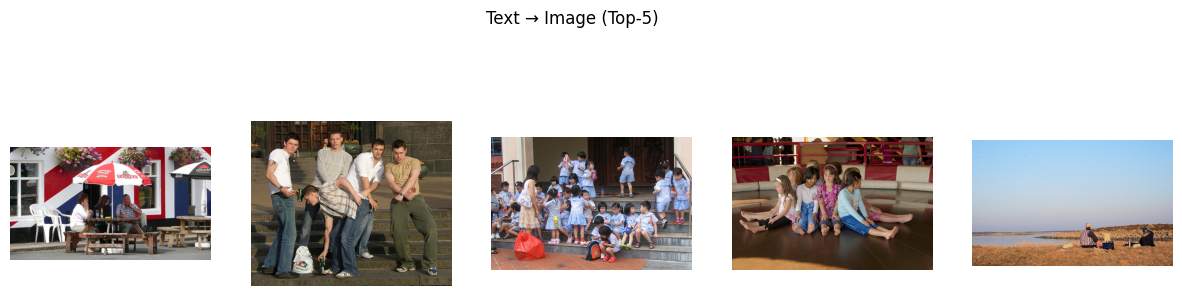

In [69]:
# HF dataset (Flickr8k)
from datasets import load_dataset
ds = load_dataset("jxie/flickr8k")

query_idx = 10  # choose any test caption index
query_text = ds["test"][query_idx]["caption_0"]

def load_image_by_idx(idx):
    return ds["test"][int(idx)]["image"]

images, indices = text_to_image_retrieval(
    query_text_idx=query_idx,
    text_embs=text_embs,
    image_embs=image_embs,
    image_ids=image_ids,
    image_loader_fn=load_image_by_idx,
    k=5
)

print("Query text:", query_text)
show_images(images, title="Text → Image (Top-5)")


In [70]:
def image_to_text_retrieval(
    query_image_idx,
    image_embs,
    text_embs,
    text_ids,
    caption_loader_fn,
    k=5
):
    query_emb = image_embs[query_image_idx].reshape(1, -1)

    sim = cosine_similarity(query_emb, text_embs)[0]
    topk_idx = np.argsort(sim)[::-1][:k]

    captions = [caption_loader_fn(idx) for idx in topk_idx]
    return captions, topk_idx


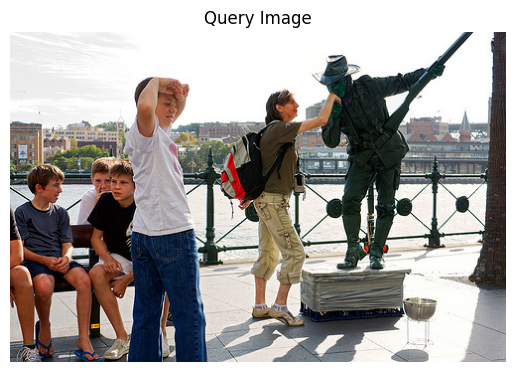

Top-5 retrieved captions:
- A group of people watching a snowboarder perform a trick .
- Three women standing on a city street .
- A group of men are standing around during a sports game in a park .
- A man and two women standing by a wood pole in front of steps .
- A crowd of people walk down a busy sidewalk .


In [72]:
query_img_idx = 10
query_image = ds["test"][query_img_idx]["image"]

def load_caption_by_idx(idx):
    return ds["test"][int(idx)]["caption_0"]

captions, indices = image_to_text_retrieval(
    query_image_idx=query_img_idx,
    image_embs=image_embs,
    text_embs=text_embs,
    text_ids=text_ids,
    caption_loader_fn=load_caption_by_idx,
    k=5
)

plt.imshow(query_image)
plt.axis("off")
plt.title("Query Image")
plt.show()

print("Top-5 retrieved captions:")
for c in captions:
    print("-", c)
